# DISTILBERT WORKFLOW (UNESCO DATASET)

Status: **DONE**

In [11]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../..")))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import  ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
# from sklearn.preprocessing import LabelEncoder
from datasets import Dataset, DatasetDict
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    TrainingArguments,
    Trainer,
)
import torch
# from tensorflow.keras.utils import to_categorical

import importlib

from shared.metrics import compute_classic_metrics, save_evaluation_report
importlib.reload(sys.modules['shared.metrics'])


<module 'shared.metrics' from 'c:\\Users\\mosqu\\personal-projects\\dss_pit\\src\\shared\\metrics.py'>

In [12]:
# LOAD DATASET
df = pd.read_csv("../../../data/uci/cleaned_covid_lies.csv")

# df.columns = ["text", "label"]

df.columns = ["X", "Y"]


print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())
print("\nLabel distribution:")
print(df['Y'].value_counts())
print("NaN Values:", df.isna().sum())

Dataset shape: (6591, 2)

First 5 rows:
                                                   X   Y
0                 coronavirus genetically engineered  na
1   blowing conch shell destroys coronavirus potency  na
2  swan dolphin swimming venice canal following c...  na
3                           cocaine cure coronavirus  na
4  observing janata curfew result reduction covid...  na

Label distribution:
Y
na     6149
pos     288
neg     154
Name: count, dtype: int64
NaN Values: X    0
Y    0
dtype: int64


In [13]:
df

,X,Y
0,coronavirus genetically engineered,na
1,blowing conch shell destroys coronavirus potency,na
2,swan dolphin swimming venice canal following c...,na
3,cocaine cure coronavirus,na
4,observing janata curfew result reduction covid...,na
...,...,...
6586,safe individual infected covid go work,na
6587,vitamin c cure coronavirus,na
6588,cocaine cure coronavirus,na
6589,lion freed keep people street moscow,na


In [15]:
# LABEL ENCODING
label_list = df['Y'].unique().tolist()
label_to_id = {label: i for i, label in enumerate(label_list)}
id_to_label = {i: label for i, label in enumerate(label_list)}
NUM_CLASSES = len(label_list)

df['label'] = df['Y'].map(label_to_id)

print(f"Labels mapped to IDs: {label_to_id}")
print(df)

Labels mapped to IDs: {'na': 0, 'pos': 1, 'neg': 2}
                                                      X   Y  label
0                    coronavirus genetically engineered  na      0
1      blowing conch shell destroys coronavirus potency  na      0
2     swan dolphin swimming venice canal following c...  na      0
3                              cocaine cure coronavirus  na      0
4     observing janata curfew result reduction covid...  na      0
...                                                 ...  ..    ...
6586             safe individual infected covid go work  na      0
6587                         vitamin c cure coronavirus  na      0
6588                           cocaine cure coronavirus  na      0
6589               lion freed keep people street moscow  na      0
6590            holy communion cause spread coronavirus  na      0

[6591 rows x 3 columns]


In [16]:
# SPLITTING TO TRAIN/TEST SETS

train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['Y']
)

hf_train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
hf_test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))

raw_datasets = DatasetDict({
    'train': hf_train_dataset,
    'test': hf_test_dataset
})

In [17]:
# TOKENIZATION

MODEL_NAME = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)
MAX_SEQUENCE_LENGTH = 128 # Typical maximum length for BERT-style models

def tokenize_function(examples):
    # Truncation ensures max length is respected, padding ensures all inputs have the same length
    return tokenizer(
        examples['X'],
        truncation=True,
        padding='max_length',
        max_length=MAX_SEQUENCE_LENGTH
    )

# Apply tokenization to the entire dataset
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

# Select the required columns and rename 'label' (for the model)
tokenized_datasets = tokenized_datasets.remove_columns(['X', 'Y'])
tokenized_datasets.set_format("torch", columns=['input_ids', 'attention_mask', 'label'])

# Final train and test sets
train_dataset = tokenized_datasets["train"]
test_dataset = tokenized_datasets["test"]

Map: 100%|██████████| 1319/1319 [00:00<00:00, 8294.95 examples/s]


In [18]:
# LOAD PRE-TRAINED MODEL

model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_CLASSES,
    id2label=id_to_label,
    label2id=label_to_id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# CUSTOM METRICS FUNCTION

def compute_metrics(eval_pred):
    """Calculates accuracy and weighted F1 score."""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Calculate accuracy
    acc = accuracy_score(labels, predictions)
    
    # Calculate weighted F1 score (good for imbalance)
    f1 = f1_score(labels, predictions, average='weighted')
    
    return {
        'accuracy': acc,
        'f1_weighted': f1,
    }

In [20]:
OUTPUT_DIR = "../../../deep_models/uci_results/distilbert_results"

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=3,                     # Number of training epochs
    per_device_train_batch_size=16,         # Batch size per device during training
    per_device_eval_batch_size=16,          # Batch size for evaluation
    warmup_steps=500,                       # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,                      # Strength of weight decay
    logging_dir='./logs',                   # Directory for storing logs
    logging_steps=50,
    eval_strategy="epoch",            # Evaluate at the end of each epoch
    save_strategy="epoch",                  # Save checkpoint at the end of each epoch
    load_best_model_at_end=True,            # Load the best model found during training
    metric_for_best_model="f1_weighted",    # Optimize for F1 score
)

In [21]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

print("Starting DistilBERT fine-tuning...")
# Train the model
trainer.train()

print("Training finished. Evaluating on the test set...")

C:\Users\mosqu\AppData\Local\Temp\ipykernel_19296\371486940.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting DistilBERT fine-tuning...


c:\Users\mosqu\personal-projects\dss_pit\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted
1,0.199100,0.212842,0.932525,0.899965
2,0.231100,0.201790,0.939348,0.915590
3,0.209700,0.198287,0.939348,0.915590


c:\Users\mosqu\personal-projects\dss_pit\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\mosqu\personal-projects\dss_pit\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Training finished. Evaluating on the test set...


In [22]:
# Evaluate the best model on the test set
results = trainer.evaluate()

print("\n--- Final Evaluation Results ---")
print(f"Accuracy: {results['eval_accuracy']:.4f}")
print(f"Weighted F1 Score: {results['eval_f1_weighted']:.4f}")

# Generate detailed classification report
predictions_output = trainer.predict(test_dataset)
predictions = np.argmax(predictions_output.predictions, axis=1)
true_labels = test_dataset['label']

print("\n--- Detailed Classification Report ---")
print(classification_report(true_labels, predictions, target_names=label_list))

# Save the final model and tokenizer
trainer.save_model(f'{OUTPUT_DIR}/final_model')
tokenizer.save_pretrained(f'{OUTPUT_DIR}/final_model')

print(f"\nModel and tokenizer saved to: {OUTPUT_DIR}/final_model")

c:\Users\mosqu\personal-projects\dss_pit\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



--- Final Evaluation Results ---
Accuracy: 0.9393
Weighted F1 Score: 0.9156


c:\Users\mosqu\personal-projects\dss_pit\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



--- Detailed Classification Report ---


c:\Users\mosqu\personal-projects\dss_pit\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\mosqu\personal-projects\dss_pit\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\mosqu\personal-projects\dss_pit\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support

          na       0.94      1.00      0.97      1230
         pos       0.00      0.00      0.00        58
         neg       0.58      0.35      0.44        31

    accuracy                           0.94      1319
   macro avg       0.51      0.45      0.47      1319
weighted avg       0.89      0.94      0.92      1319


Model and tokenizer saved to: ../../../deep_models/uci_results/distilbert_results/final_model


In [23]:
# metrics for saving
metrics = compute_classic_metrics(true_labels, predictions)

print("Accuracy:", metrics["accuracy"])
print("F1 Score:", metrics["f1_score"])
print(metrics["report"])

Accuracy: 0.9393479909021987
F1 Score: 0.9155903831804548
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1230
           1       0.00      0.00      0.00        58
           2       0.58      0.35      0.44        31

    accuracy                           0.94      1319
   macro avg       0.51      0.45      0.47      1319
weighted avg       0.89      0.94      0.92      1319



c:\Users\mosqu\personal-projects\dss_pit\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\mosqu\personal-projects\dss_pit\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\mosqu\personal-projects\dss_pit\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

In [24]:
cm = confusion_matrix(true_labels, predictions)
print("Raw confusion matrix:")
print(cm)

Raw confusion matrix:
[[1228    0    2]
 [  52    0    6]
 [  20    0   11]]


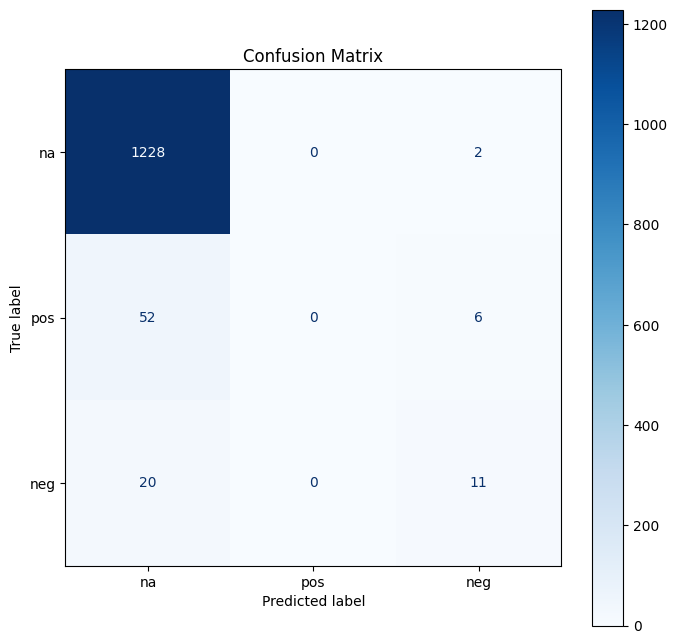

In [25]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_list)

# Adjust the plot size and color map
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d') # 'd' formats as integer
plt.title("Confusion Matrix")
plt.show()

In [26]:
# SAVING EVAL REPORT
save_evaluation_report(metrics, "../../../deep_models/uci_results/distilbert_evaluation_report.json")

Evaluation report saved to ../../../deep_models/uci_results/distilbert_evaluation_report.json
